## Imports

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

import sys
import pickle
import wandb

import torch.optim as optim


from utils.miscellaneous import read_config
from utils.miscellaneous import create_folder_structure_MLPvsGNN
from utils.miscellaneous import initalize_random_generators
from utils.wandb_logger import save_response_graphs_in_ML_tracker
from utils.normalization import *
from utils.load import *

from training.train import training
from training.test import testing
from training.models import * 

from utils.visualization import plot_R2, plot_loss
from matplotlib import pyplot as plt

### Parse configuration file + initializations


In [2]:
# read config files
cfg = read_config("config_unrolling.yaml")
# create folder for result
exp_name = cfg['exp_name']
data_folder = cfg['data_folder']
results_folder = create_folder_structure_MLPvsGNN(cfg, parent_folder='./experiments')

all_wdn_names = cfg['networks']
initalize_random_generators(cfg, count=0)

# initialize pytorch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.set_num_threads(12)

Creating folder: ./experiments/unrolling_WDN0278
cpu


In [3]:
# TO DO: at the moment I am not using the parsed values for batch size and num_epochs ;
# I am not using alpha as well because the loss has no "smoothness" penalty (yet)
batch_size = cfg['trainParams']['batch_size']
num_epochs = cfg['trainParams']['num_epochs']
alpha = cfg['lossParams']['alpha']
res_columns = ['train_loss', 'valid_loss', 'test_loss', 'max_train_loss', 'max_valid_loss', 'max_test_loss',
               'min_train_loss', 'min_valid_loss', 'min_test_loss', 'r2_train', 'r2_valid',
               'r2_test', 'total_params', 'total_time', 'test_time']

# Functions

## Models
I will be Creating different models as follows:

* A simple LSTM
* An unrolled version of Heads and Flows, without static variables
* An unrolled version with Heads, Flows and static variables


## Running experiments

In [4]:
g_normalizers = []
for ix_wdn, wdn in enumerate(all_wdn_names):
    print(f'\nWorking with {wdn}, network {ix_wdn + 1} of {len(all_wdn_names)}')

    # retrieve wntr data
    tra_database, val_database, tst_database = load_raw_dataset(wdn, data_folder)
    # reduce training data
    # tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
    if cfg['tra_num'] < len(tra_database):
        tra_database = tra_database[:cfg['tra_num']]

    # remove PES anomaly
    if wdn == 'PES':
        if len(tra_database) > 4468:
            del tra_database[4468]
            print('Removed PES anomaly')
            print('Check', tra_database[4468].pressure.mean())

    # get GRAPH datasets     
    # later on we should change this and use normal scalers from scikit (something is off here)
    tra_dataset, A12_bar = create_dataset(tra_database)

    gn = GraphNormalizer()
    gn = gn.fit(tra_dataset)
    g_normalizers.append(gn)
    # The normalization messed with the 1H_type since we want unique IDs
    tra_dataset, _ = create_dataset(tra_database, normalizer=gn)
    val_dataset, _ = create_dataset(val_database, normalizer=gn)
    tst_dataset, _ = create_dataset(tst_database, normalizer=gn)
    node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
    # number of nodes
    n_nodes = (tra_database[0].node_type == 0).numpy().sum() + (
            tra_database[0].node_type == 2).numpy().sum()  # remove reservoirs
    # dataloader
    # transform dataset for MLP
    # We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
    A10, A12 = create_incidence_matrices(tra_dataset, A12_bar)
    tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
    val_dataset_MLP = create_dataset_MLP_from_graphs(val_dataset)[0]
    tst_dataset_MLP = create_dataset_MLP_from_graphs(tst_dataset)[0]
    tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
                                             batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    tst_loader = torch.utils.data.DataLoader(tst_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    # loop through different algorithms
    for algorithm in cfg['algorithms']:
        # Importing of configuration parameters
        hyperParams = cfg['hyperParams'][algorithm]
        all_combinations = ParameterGrid(hyperParams)

        # create results dataframe
        results_df = pd.DataFrame(list(all_combinations))
        results_df = pd.concat([results_df,
                                pd.DataFrame(index=np.arange(len(all_combinations)),
                                             columns=list(res_columns))], axis=1)

        for i, combination in enumerate(all_combinations):
            # wandb.init(project="unrolling-epanet", entity="mertz")
            print(f'{algorithm}: training combination {i + 1} of {len(all_combinations)}\n')
            
            combination['indices'] = indices
            combination['num_outputs'] = n_nodes

            # model creation
            model = getattr(sys.modules[__name__], algorithm)(**combination).float().to(device)

            # get combination dictionary to determine how are indices made
            # print("Model", model, combination) 

            total_parameters = sum(p.numel() for p in model.parameters())

            # model optimizer
            optimizer = optim.Adam(params=model.parameters(), betas=(0.9, 0.999), **cfg['adamParams'])

            # training
            patience = cfg['earlyStopping']['patience']
            lr_rate = cfg['earlyStopping']['divisor']
            lr_epoch = cfg['earlyStopping']['epoch_frequency']
            train_config = {"Patience": patience, "Learning Rate Divisor": lr_rate, "LR Epoch Division": lr_epoch}
            model, tra_losses, val_losses, elapsed_time = training(model, optimizer, tra_loader, val_loader,
                                                                   patience=patience, report_freq=0,
                                                                   n_epochs=num_epochs,
                                                                   alpha=alpha, lr_rate=lr_rate, lr_epoch=lr_epoch,
                                                                   normalization=None,
                                                                   path=f'{results_folder}/{wdn}/{algorithm}/')
            loss_plot = plot_loss(tra_losses, val_losses, f'{results_folder}/{wdn}/{algorithm}/loss/{i}')
            R2_plot = plot_R2(model, val_loader, f'{results_folder}/{wdn}/{algorithm}/R2/{i}', normalization=gn)[1]
            # store training history and model
            pd.DataFrame(data=np.array([tra_losses, val_losses]).T).to_csv(
                f'{results_folder}/{wdn}/{algorithm}/hist/{i}.csv')
            torch.save(model, f'{results_folder}/{wdn}/{algorithm}/models/{i}.csv')

            # compute and store predictions, compute r2 scores
            losses = {}
            max_losses = {}
            min_losses = {}
            r2_scores = {}
            for split, loader in zip(['training', 'validation', 'testing'], [tra_loader, val_loader, tst_loader]):
                losses[split], max_losses[split], min_losses[split], pred, real, test_time = testing(model, loader,
                                                                                                     normalization=gn)
                r2_scores[split] = r2_score(real, pred)
                if i == 0:
                    pd.DataFrame(data=real.reshape(-1, n_nodes)).to_csv(
                        f'{results_folder}/{wdn}/{algorithm}/pred/{split}/real.csv')  # save real obs
                pd.DataFrame(data=pred.reshape(-1, n_nodes)).to_csv(
                    f'{results_folder}/{wdn}/{algorithm}/pred/{split}/{i}.csv')

            # log_wandb_data(combination, wdn, algorithm, len(tra_database), len(val_database), len(tst_database), cfg, train_config, loss_plot, R2_plot)
            # store results
            results_df.loc[i, res_columns] = (losses['training'], losses['validation'], losses['testing'],
                                              max_losses['training'], max_losses['validation'], max_losses['testing'],
                                              min_losses['training'], min_losses['validation'], min_losses['testing'],
                                              r2_scores['training'], r2_scores['validation'], r2_scores['testing'],
                                              total_parameters, elapsed_time, test_time)


        # wandb.finish()
        # save graph normalizer
        with open(f'{results_folder}/{wdn}/{algorithm}/gn.pickle', 'wb') as handle:
            pickle.dump(gn, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(f'{results_folder}/{wdn}/{algorithm}/model.pickle', 'wb') as handle:
            torch.save(model, handle)
        results_df.to_csv(f'{results_folder}/{wdn}/{algorithm}/results_{algorithm}.csv')



Working with FOS_tank, network 1 of 1
UnrollingModel: training combination 1 of 1


100%|██████████| 20/20 [00:00<00:00, 28.87it/s]


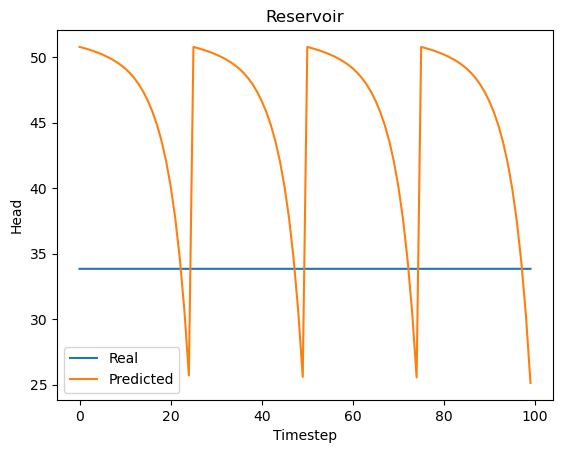

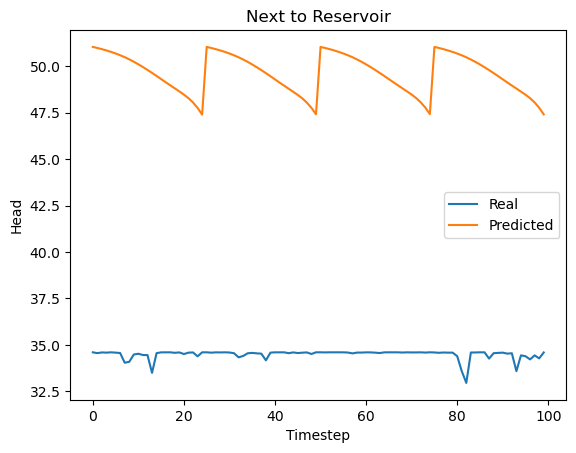

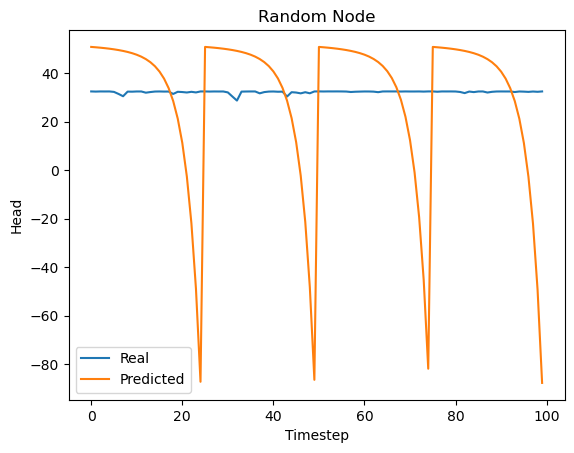

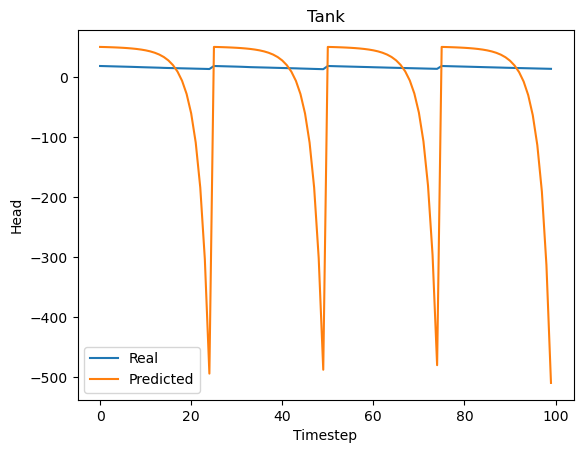

In [5]:
from utils.Dashboard import Dashboard
from IPython.display import display

_, _, _, pred, real, time = testing(model, val_loader, normalization=gn)
pred = gn.inverse_transform_array(pred, 'pressure')
real = gn.inverse_transform_array(real, 'pressure')
pred = pred.reshape(-1, n_nodes)
real = real.reshape(-1, n_nodes)

# Array below is created to ensure proper indexing of the nodes when displaying
type_array = (val_database[0].node_type == 0) | (val_database[0].node_type == 2)
d = Dashboard(pd.DataFrame(real[0:24, :]), pd.DataFrame(pred[0:24, :]),
              to_networkx(val_dataset[0], node_attrs=['pos', 'ID']), type_array)
# f = d.display_results()

for i in [0, 1, 7, 36]:
    plt.plot(real[0:100, i], label="Real")
    plt.plot(pred[0:100, i], label="Predicted")
    plt.ylabel('Head')
    plt.xlabel('Timestep')
    
    plt.legend()
    names = {0: 'Reservoir', 1: 'Next to Reservoir', 7: 'Random Node', 36: 'Tank'}
    plt.title(names[i])
    plt.show()
    plt.close()

# Create a table

# Add Plotly figure as HTML file into Table
# table = wandb.Table(columns = ["Figure" + str(i)])
# with open('./my_HTML_' + str(i) + '.html', 'r', encoding='utf-8') as file:
# 	html_content = file.read()
# table.add_data(wandb.Html(html_content))
# display(f)
# wandb.finish()

In [6]:
import os
import regex as re

# Directory path where you want to search
directory_path = "./experiments"

# Get a list of all subdirectories in the specified directory
subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Filter and extract the numbers from directory names
wdn_numbers = []
for subdir in subdirectories:
    match = re.match(r'unrolling_WDN(\d{4})', subdir)
    if match:
        wdn_numbers.append(int(match.group(1)))

# Find the latest WDN number
latest_wdn_number = None
if wdn_numbers:
    latest_wdn_number = max(wdn_numbers)
    latest_wdn_folder = f'unrolling_WDN{latest_wdn_number:04d}'
    print(f"The latest WDN folder is: {latest_wdn_folder}")
else:
    print("No WDN folders found in the specified directory.")

if latest_wdn_folder is not None:
    real = pd.read_csv(f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/real.csv').drop(
        columns=['Unnamed: 0'])
    lstm_pred = pd.read_csv(
        f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/0.csv').drop(
        columns=['Unnamed: 0'])
    unrolling_pred = pd.read_csv(
        f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/BaselineUnrolling/pred/testing/0.csv').drop(
        columns=['Unnamed: 0'])

The latest WDN folder is: unrolling_WDN0278


FileNotFoundError: [Errno 2] No such file or directory: './experiments/unrolling_WDN0278/FOS_tank/LSTM/pred/testing/real.csv'

In [ ]:
import matplotlib.pyplot as plt

# Not sure if below makes sense since we now have an extra dimension
res = real.sub(lstm_pred).pow(2).sum(axis=0)
tot = real.sub(lstm_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_lstm = 1 - res / tot
res = real.sub(unrolling_pred).pow(2).sum(axis=0)
tot = real.sub(unrolling_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_unrolling = 1 - res / tot
r2s = pd.concat([r2_lstm, r2_unrolling], axis=1).rename(columns={0: 'LSTM', 1: 'Base-U'})
fig, ax = plt.subplots()
r2s.plot.box(ax=ax)
ax.set_title("$R^2$ Scores Comparison for PES")
ax.set_ylabel('$R^2$ Score')
plt.show()

In [ ]:
model = torch.load(f'{results_folder}/{wdn}/{algorithm}/model.pickle')